# MyStrategy 
We can't decide when the opponents buy and sell, but we can decide to hedge or hold the open position. My method is generate our long & short signal (Here I pick Future B and use Moving Average to generate long & short signal). 

If the opponents offer the trading we want to do (e.g. the opponent wants to sell and I want to buy), I will hold the opening position till my signal disappear.
Other case, we simply hedging the opening position by simultaneously get entered long and short (e.g. the opponent wants to sell, so I buy it and sell it immediately).

We should also satisfied the our opening should smaller than the largest opening position L.

# Pseudocode
(opponent buy signal == 1) & (own sell signal == 1) => sell and hold
(opponent sell signal == 1) & (own buy signal == 1) => buy and hold

long_pos > L => reduce long position to L
short_pos > L => reduce short position to L
(own sell signal == 0) & (short_pos > 0) => clean short position to 0
(own buy signal == 0) & (long_pos > 0) => clean long position to 0

in other case
opponent buy signal == 1 => buy and sell immediately
opponent sell signal == 1 => sell and buy immediately


In [1]:
import random
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
import time
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('expand_frame_repr', False)  # show all column in a raw
pd.set_option('display.max_rows', None) # show all rows


In [2]:
def strategy(df, long_pos, short_pos, L, S):
    for i in range(1, len(df['Date'])):
        #price of B over its MA X std
        if df['buy+hold'].iloc[i] == 1:
            long_pos += S
            if long_pos <= L:
                df['long_pos'].iloc[i] = long_pos
            elif long_pos > L:
                df['sell_long>L'].iloc[i] = long_pos - L
                long_pos = L
                df['long_pos'].iloc[i] = long_pos
        elif df['buy+hold'].iloc[i] == 0:
            if df['long_pos'].iloc[i-1] > 0:
                if df['ma_buy'].iloc[i] == 0:
                    long_pos = 0
                    df['long_pos'].iloc[i] = long_pos
                elif df['ma_buy'].iloc[i] == 1:
                    df['long_pos'].iloc[i] = long_pos
            #elif df['long_pos'].iloc[i] == 0:
                
                    

        if df['sell+hold'].iloc[i] == 1:
            short_pos += S
            if short_pos <= L:
                df['short_pos'].iloc[i] = short_pos
            elif short_pos > L:
                df['buy_short>L'].iloc[i] = short_pos - L
                short_pos = L
                df['short_pos'].iloc[i] = short_pos
        elif df['sell+hold'].iloc[i] == 0:
            if df['short_pos'].iloc[i-1] > 0:
                if df['ma_sell'].iloc[i]  == 0:
                    short_pos = 0
                    df['short_pos'].iloc[i] = short_pos
                elif df['ma_sell'].iloc[i] == 1:
                    df['short_pos'].iloc[i] = short_pos
            #elif df['short_pos'].iloc[i] == 0:
    return df
        

In [3]:
# if __name__ == '__main__':
def f():
    # import data and data cleaning
    data_a = pd.read_csv(r'futuresA.csv')
    data_b = pd.read_csv(r'futuresB.csv')
    df = data_b.copy()
    
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df = df.sort_values(by='Date', ascending=True, ignore_index=True)
    #df.set_index(['Date'], inplace=True)
    #set random num, find out where we have to sell and buy due to opponents
    df['random1'] = 0
    df['random2'] = 0
    for i in range(len(df['Date'])):
        random.seed(i)
        df['random1'].iloc[i] = random.random()
        df['random2'].iloc[i] = random.random()
    df.loc[df['random1']<p1,'opp_buy'] = 1
    df.loc[df['random2']<p2,'opp_sell'] = 1
    #del df['random1'],df['random2']
    
    
    #use ma+_std to decide whether we should hedge or hold
    df['MA_B'] = df['Close'].ewm(span=N).mean()
    df['Std_B'] = df['Close'].ewm(span=N).std()
    df.loc[df['Close'] > df['MA_B']+X*df['Std_B'], 'ma_buy'] = 1
    df.loc[df['Close'] < df['MA_B']-Y*df['Std_B'], 'ma_sell'] = 1
    
    df = df.fillna(0)
    df.loc[(df['opp_buy'] == 1) & (df['ma_sell'] == 0), 'sell+buy'] = 1
    df.loc[(df['opp_buy'] == 1) & (df['ma_sell'] == 1), 'sell+hold'] = 1
    df.loc[(df['opp_sell'] == 1) & (df['ma_buy'] == 0), 'buy+sell'] = 1
    df.loc[(df['opp_sell'] == 1) & (df['ma_buy'] == 1), 'buy+hold'] = 1
    df = df.fillna(0)
    
    # exacute strategy
    df['long_pos'] = 0
    df['short_pos'] = 0
    df['buy_short>L'] = 0
    df['sell_long>L'] = 0
    strategy(df, long_pos, short_pos, L, S)
    
    # df[['long_pos','short_pos']] = df[['long_pos','short_pos']].ffill()
    # df[['buy_short>L','sell_long>L']] = df[['buy_short>L','sell_long>L']].fillna(0)
    
    #culculate return
    df['fee'] = 2 * (C-M) * (df['sell+buy']+df['buy+sell']) + 2 * C * (df['buy_short>L']+df['sell_long>L'])+ 1 * (C-M)* (df['sell+hold']+df['buy+hold'])
    
    df['return'] = (df['Close']-df['Close'].shift(1)) * (df['long_pos'].shift(1)) - (df['Close']-df['Close'].shift(1)) * (df['short_pos'].shift(1)) - df['fee']
    df['return'] = df['return'].fillna(0)
    df['cumreturn'] = df['return'].cumsum()
    
    df = df[['Date', 'opp_buy', 'opp_sell', 'ma_buy', 'ma_sell', 'sell+buy', 'sell+hold', 'buy+sell', 'buy+hold', 'long_pos', 'short_pos', 'fee', 'return', 'cumreturn']]
    # print(df)
    draw = df[['Date', 'fee', 'cumreturn']].copy()
    
    # print(r'fee=%s'% df['fee'].sum())
    # print(r'cumreturn=%s'% df['return'].sum())
    return(df['fee'].sum(), df['return'].sum(), draw)

In [4]:
# initialization you can change the parameter here
# p1 = 0.5 # P_buy
# p2 = 0.5 # P_sell
S = 500 # buy & sell size
C = 1 # trading costs (cast C to trade one unit of future)
M = -0.5 # trading liquidity reward (minus means the reward is negative)
L = 100000 # opening position limit

N = 30 # MA span
X = 0.8 # above X std
Y = 0.8 # below Y std
long_pos = 0 # long position
short_pos = 0 # short position

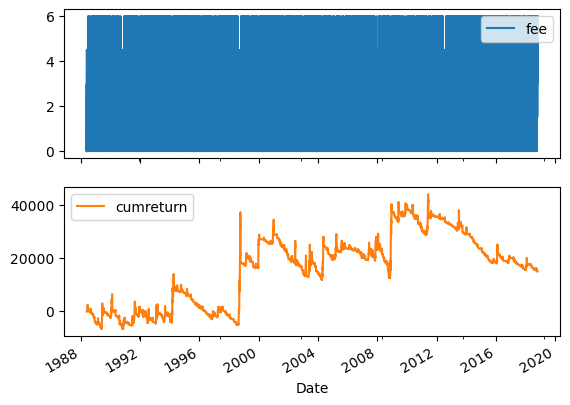

fee=20427.0
cumreturn=14955.80975000003


In [5]:
p1 = 0.5
p2 = 0.5
a,b,draw = f()
draw.set_index(['Date'], inplace=True)
draw.plot(kind='line', subplots=True) 
plt.show()
print(r'fee=%s'% a)
print(r'cumreturn=%s'% b)

In [6]:
fee = np.empty((11,11))
cumreturn = np.empty((11,11))
draw = pd.DataFrame()
for i in range(11):
    for j in range(11):
        p1 = i/10
        p2 = j/10
        fee[i][j], cumreturn[i][j], draw= f()
print(fee)
print(cumreturn)


[[    0.   2022.   4096.5  6013.5  8080.5 10164.  12102.  14151.  16108.5
  18060.  20016. ]
 [ 2158.5  4180.5  6255.   8172.  10239.  12322.5 14260.5 16309.5 18267.
  20218.5 22174.5]
 [ 4207.5  6229.5  8304.  10221.  12288.  14371.5 16309.5 18358.5 20316.
  22267.5 24223.5]
 [ 6177.   8199.  10273.5 12190.5 14257.5 16341.  18279.  20328.  22285.5
  24237.  26193. ]
 [ 8251.5 10273.5 12348.  14265.  16332.  18415.5 20353.5 22402.5 24360.
  26311.5 28267.5]
 [10263.  12285.  14359.5 16276.5 18343.5 20427.  22365.  24414.  26371.5
  28323.  30279. ]
 [12384.  14406.  16480.5 18397.5 20464.5 22548.  24486.  26535.  28492.5
  30444.  32400. ]
 [14437.5 16459.5 18534.  20451.  22518.  24601.5 26539.5 28588.5 30546.
  32497.5 34453.5]
 [16458.  18480.  20554.5 22471.5 24538.5 26622.  28560.  30609.  32566.5
  34518.  36474. ]
 [18409.5 20431.5 22506.  24423.  26490.  28573.5 30511.5 32560.5 34518.
  36469.5 38425.5]
 [20401.5 22423.5 24498.  26415.  28482.  30565.5 32503.5 34552.5 36510.
  

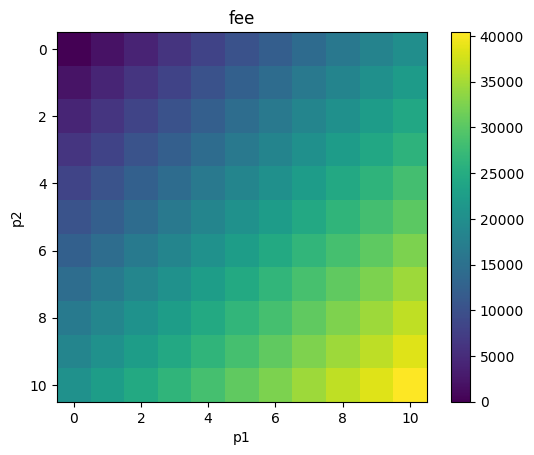

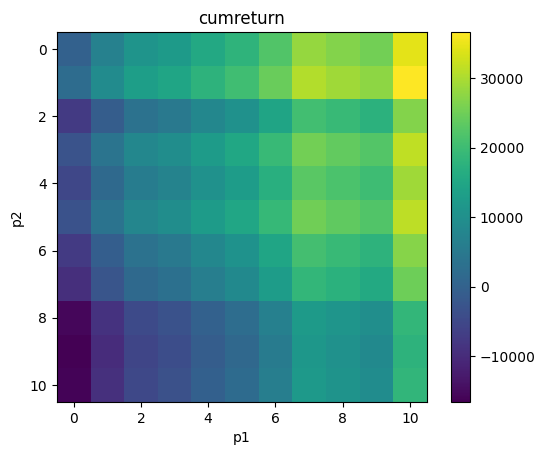

In [7]:
plt.figure()
plt.imshow(fee, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('fee')
plt.xlabel('p1')
plt.ylabel('p2')
plt.show()

plt.figure()
plt.imshow(cumreturn, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('cumreturn')
plt.xlabel('p1')
plt.ylabel('p2')
plt.show()


# Conclusion
1. The trading size should be large enough. So the little profit we gain from the price difference can accumulate and cover the cost of fee. Here I pick L=100000, S=500. Of course the change of cost C and reward M make a great difference, here I use the M<=0.
2. I think there is some relation between p1 and p2. I can't tell it. However, it seems that when p1 is large, the general performance is good. But
3. Some parameters of my strategy can make money when M<=0. Performance can be imporve by making better signal to decide whether we should hedge or hold the open position (some advanced method better than Moving Average method I apply here).